# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
label = "nPH"
nmax = 4

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [3]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")

## Example Fit / Calibration & Prediction

In [5]:
model = Bayes(traindata, nmax, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(4, 4), (3, 4), (3, 3), (2, 2), (2, 2), (3, 3), (2, 2), (3, 4), (2, 1), (1, 1), (1, 1), (4, 4), (3, 2), (2, 2), (3, 3), (2, 2), (4, 4), (1, 1), (4, 3), (3, 3), (1, 1), (3, 2), (3, 3), (4, 4), (1, 1), (4, 4), (1, 1), (2, 3), (2, 2), (3, 3), (2, 2), (0, 0), (2, 2), (1, 2), (1, 1), (4, 4), (1, 1), (3, 3), (2, 2), (1, 2), (2, 1), (4, 4), (2, 2), (4, 4), (4, 4), (1, 1), (2, 2), (4, 4), (1, 1), (3, 3)]


In [6]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.7880497546051423
[[ 2042     2     0     1     1]
 [    1 38259  3876    19     8]
 [    1  5786 28860  6888   118]
 [    0   303  7768 24034  9043]
 [    5     3   633  7271 24761]]
[[100.   0.   0.   0.   0.]
 [  0.  91.   9.   0.   0.]
 [  0.  14.  69.  17.   0.]
 [  0.   1.  19.  58.  22.]
 [  0.   0.   2.  22.  76.]]


Text(69.0, 0.5, 'True')

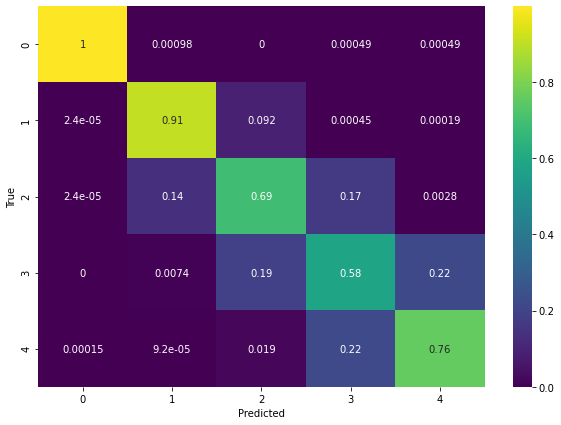

In [7]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [8]:
for n in [1, 2, 3, 4, 5]:
    traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=n, physics="inclxx")

    model = Bayes(traindata, n, label)
    y_pred = model.predict(testdata)
    y_true = testdata[label].values.ravel()

    bac = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
    print(cm)
    print(n, bac)

[[ 1966     1]
 [   14 38033]]
1 0.9995618228271941
[[ 2136     3     1]
 [    8 37738  3872]
 [    4  5051 31410]]
2 0.9220919566579514
[[ 2108     1     0     0]
 [    1 38202  3811    25]
 [    2  5729 28828  7110]
 [    8   258  6383 27633]]
3 0.8515341327772772
[[ 2093     2     1     1     2]
 [    0 38140  3857    21     5]
 [    1  5764 29071  7032   128]
 [    1   306  7761 23973  8991]
 [    4     9   649  7194 24848]]
4 0.7882016722822617
[[ 2106     0     0     1     2     0]
 [    1 38233  3800    20     1     5]
 [    0  5806 29040  7029    98     8]
 [    0   299  8081 24663  8727   401]
 [    1    12   812  8729 20445 10172]
 [    1     0    26  1083  7271 22961]]
5 0.7376179374270776
